# PROJET SPARK - Charger et traiter les données sur le prix du gaz avec Spark

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import warnings 
warnings.filterwarnings('ignore')

import pyspark
#import os

from pyspark.sql.functions import *
from pyspark.sql.types import * 
from pyspark.sql import *

import pygal.maps.fr
import pyspark.sql.functions as func

In [2]:
#os.environ['JAVA_HOME'] = '/Library/Java/JavaVirtualMachines/jdk-10.0.2.jdk/Contents/Home'

In [3]:
#os.environ['SPARK_HOME'] = '/Users/marionaurat/Downloads/spark-2.3.1-bin-hadoop2.7'

In [4]:
sc = pyspark.SparkContext()

In [5]:
sc._conf.getAll()

[('spark.driver.port', '50917'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.id', 'local-1545386811091'),
 ('spark.driver.host', '147.94.77.46'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'pyspark-shell')]

In [6]:
sqlsc = pyspark.SQLContext(sc)

In [7]:
spark = sqlsc.sparkSession

# Step 1 - Fusion des fichiers de prix du gaz

### Collecte de données : lecture et fusion de tous les fichiers de gaz

In [8]:
prix2015_df = sqlsc.read.option('sep',';').option('header','false').option('inferSchema','true').csv('/Users/marionaurat/Downloads/Prix2015.csv')
prix2016_df = sqlsc.read.option('sep',';').option('header','false').option('inferSchema','true').csv('/Users/marionaurat/Downloads/Prix2016.csv')
prix2017_df = sqlsc.read.option('sep',';').option('header','false').option('inferSchema','true').csv('/Users/marionaurat/Downloads/Prix2017.csv')
prix2018_df = sqlsc.read.option('sep',';').option('header','false').option('inferSchema','true').csv('/Users/marionaurat/Downloads/Prix2018.csv')

prix_df = prix2015_df.union(prix2016_df).union(prix2017_df).union(prix2018_df)

In [9]:
prix_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: integer (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: timestamp (nullable = true)
 |-- _c6: integer (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: integer (nullable = true)



In [10]:
prix_df.show(5)

+-------+----+---+---------+--------+-------------------+---+------+----+
|    _c0| _c1|_c2|      _c3|     _c4|                _c5|_c6|   _c7| _c8|
+-------+----+---+---------+--------+-------------------+---+------+----+
|1000001|1000|  R|4620114.0|519791.0|2015-01-02 11:01:45|  1|Gazole|1141|
|1000001|1000|  R|4620114.0|519791.0|2015-01-03 09:01:42|  1|Gazole|1141|
|1000001|1000|  R|4620114.0|519791.0|2015-01-07 10:01:44|  1|Gazole|1141|
|1000001|1000|  R|4620114.0|519791.0|2015-01-08 10:01:06|  1|Gazole|1115|
|1000001|1000|  R|4620114.0|519791.0|2015-01-09 10:01:19|  1|Gazole|1115|
+-------+----+---+---------+--------+-------------------+---+------+----+
only showing top 5 rows



In [11]:
prix_df.count()

14192497

### Séparer la date en 3 : année, mois et semaine de l'année

In [12]:
from pyspark.sql.functions import to_date, date_format

In [13]:
prix_df = prix_df.withColumn("annee", date_format(to_date("_c5", "yyyy-MM-dd"), "y"))
prix_df = prix_df.withColumn("mois", date_format(to_date("_c5", "yyyy-MM-dd"), "M"))
prix_df = prix_df.withColumn("semaine", date_format(to_date("_c5", "yyyy-MM-dd"), "w"))

Ici, on a créé 3 nouvelles variables (colones) qui sont: annee, mois et semaine.

In [14]:
prix_df.show(5)

+-------+----+---+---------+--------+-------------------+---+------+----+-----+----+-------+
|    _c0| _c1|_c2|      _c3|     _c4|                _c5|_c6|   _c7| _c8|annee|mois|semaine|
+-------+----+---+---------+--------+-------------------+---+------+----+-----+----+-------+
|1000001|1000|  R|4620114.0|519791.0|2015-01-02 11:01:45|  1|Gazole|1141| 2015|   1|      1|
|1000001|1000|  R|4620114.0|519791.0|2015-01-03 09:01:42|  1|Gazole|1141| 2015|   1|      1|
|1000001|1000|  R|4620114.0|519791.0|2015-01-07 10:01:44|  1|Gazole|1141| 2015|   1|      2|
|1000001|1000|  R|4620114.0|519791.0|2015-01-08 10:01:06|  1|Gazole|1115| 2015|   1|      2|
|1000001|1000|  R|4620114.0|519791.0|2015-01-09 10:01:19|  1|Gazole|1115| 2015|   1|      2|
+-------+----+---+---------+--------+-------------------+---+------+----+-----+----+-------+
only showing top 5 rows



### Préparer la latitude et la longitude pour la cartographie + préparer les données

Nous avons d'abord regarder le nombre de NaN

In [15]:
prix_df.filter(prix_df["_c3"].isNull()).count()

7773

In [16]:
prix_df.filter(prix_df["_c4"].isNull()).count()

7768

In [17]:
prix_df.filter(prix_df["_c5"].isNull()).count()

11170

_c5, _c6, _c7, _c8, annee, mois et semaine ont le même nombre de NaN -> 11 170.

Grâce au dropna, dans la commande suivante nous avons à la fois renommer nos colones ainsi qu'éliminer les NaN.

In [18]:
prix_df = prix_df.selectExpr(
    '_c0 as id_station', 
    '_c1 as code_postal',
    '_c2 as type_station',
    '_c3/100000 as latitude',
    '_c4/100000 as longitude',
    '_c5 as date_releve',
    '_c6 as type_carburant',
    '_c7 as libelle_carburant',
    '_c8/1000 as prix',
    'annee',
    'mois',
    'semaine'
).dropna()

In [19]:
prix_df.show(5)

+----------+-----------+------------+--------+---------+-------------------+--------------+-----------------+-----+-----+----+-------+
|id_station|code_postal|type_station|latitude|longitude|        date_releve|type_carburant|libelle_carburant| prix|annee|mois|semaine|
+----------+-----------+------------+--------+---------+-------------------+--------------+-----------------+-----+-----+----+-------+
|   1000001|       1000|           R|46.20114|  5.19791|2015-01-02 11:01:45|             1|           Gazole|1.141| 2015|   1|      1|
|   1000001|       1000|           R|46.20114|  5.19791|2015-01-03 09:01:42|             1|           Gazole|1.141| 2015|   1|      1|
|   1000001|       1000|           R|46.20114|  5.19791|2015-01-07 10:01:44|             1|           Gazole|1.141| 2015|   1|      2|
|   1000001|       1000|           R|46.20114|  5.19791|2015-01-08 10:01:06|             1|           Gazole|1.115| 2015|   1|      2|
|   1000001|       1000|           R|46.20114|  5.19791

In [20]:
prix_df.count()

14173853

### Rendre les données disponibles sous forme de table afin de pouvoir utiliser Spark SQL

In [21]:
sqlsc.registerDataFrameAsTable(prix_df, 'data_prix')

# Step 2 - Déduplication de stations

Certaines stations ont des id_station différents, mais sont en fait situées au même endroit (ce qui peut être dû à une fausse récréation, à un changement de propriétaire, etc). Cette étape permet de créer un identifiant de station unique pour l'ensemble des fichiers.

### Lire et fusionner tous les fichiers stations (2016-2018)

In [22]:
stations2016_df = spark.read.load('/Users/marionaurat/Downloads/Stations2016.csv', format='csv', sep='|', header='false', inferSchema='true', PYTHONIOENCODING='utf-8')

stations2017_df = spark.read.load('/Users/marionaurat/Downloads/Stations2017.csv', format='csv', sep='|', header='false', inferSchema='true', PYTHONIOENCODING='utf-8')

stations2018_df = spark.read.load('/Users/marionaurat/Downloads/Stations2018.csv', format='csv', sep='|', header='false', inferSchema='true', PYTHONIOENCODING='utf-8')

In [23]:
stations_df = stations2016_df.union(stations2017_df).union(stations2018_df)

In [24]:
stations_df.show(5)

+-------+----+---+-------------+-------------+--------------------+--------------------+
|    _c0| _c1|_c2|          _c3|          _c4|                 _c5|                 _c6|
+-------+----+---+-------------+-------------+--------------------+--------------------+
|1000001|1000|  R|    4620114.0|     519791.0|596 AVENUE DE TRE...|SAINT-DENIS-LèS-B...|
|1000002|1000|  R|    4621842.0|     522767.0| 16 Avenue de Marboz|     BOURG-EN-BRESSE|
|1000004|1000|  R|    4618836.0|     524447.0|20 Avenue du Maré...|     Bourg-en-Bresse|
|1000005|1000|  R|4620093.59235|519942.024022|642 Avenue de Tré...|SAINT-DENIS-LèS-B...|
|1000006|1000|  R|    4620754.0|     523758.0|1 Boulevard John ...|     BOURG-EN-BRESSE|
+-------+----+---+-------------+-------------+--------------------+--------------------+
only showing top 5 rows



In [25]:
stations_df.count()

37679

La encore on regarde le nombre de NaN.

In [26]:
stations_df.filter(stations_df["_c3"].isNull()).count()

238

In [27]:
stations_df.filter(stations_df["_c4"].isNull()).count()

235

In [28]:
stations_df.filter(stations_df["_c6"].isNull()).count()

2

In [29]:
stations_df = stations_df.selectExpr(
    '_c0 as id_station', 
    '_c1 as code_postal',
    '_c2 as type_station',
    '_c3/100000 as latitude',
    '_c4/100000 as longitude',
    '_c5 as addresse',
    '_c6 as ville',
).dropna().cache()

In [30]:
stations_df.show(5)

+----------+-----------+------------+-------------+-------------+--------------------+--------------------+
|id_station|code_postal|type_station|     latitude|    longitude|            addresse|               ville|
+----------+-----------+------------+-------------+-------------+--------------------+--------------------+
|   1000001|       1000|           R|     46.20114|      5.19791|596 AVENUE DE TRE...|SAINT-DENIS-LèS-B...|
|   1000002|       1000|           R|     46.21842|      5.22767| 16 Avenue de Marboz|     BOURG-EN-BRESSE|
|   1000004|       1000|           R|     46.18836|      5.24447|20 Avenue du Maré...|     Bourg-en-Bresse|
|   1000005|       1000|           R|46.2009359235|5.19942024022|642 Avenue de Tré...|SAINT-DENIS-LèS-B...|
|   1000006|       1000|           R|     46.20754|      5.23758|1 Boulevard John ...|     BOURG-EN-BRESSE|
+----------+-----------+------------+-------------+-------------+--------------------+--------------------+
only showing top 5 rows



In [31]:
stations_df.count()

37439

### Dédupliquer les stations en fonction de leur emplacement

Nous avons choisi de le faire en fonction de la latitute et de la longitute).

Nous avons aussi retirer les id_stations qui étaient dupliqués.

In [32]:
stations_df = stations_df.dropDuplicates(['latitude', 'longitude', 'id_station'])

In [33]:
stations_df.count()

18101

### Grouper par stations par clé(s) de déduplication sélectionnée(s), générer un ID unique

Pour cela, on a sélectionner l'id_station le plus grand (max) pour l'appliquer aux autres stations qui n'avaient pas le même id_stations mais qui avaient la même localisation (en fonction de latitude et longitude).

In [34]:
stations_unique_df = stations_df.groupBy(['latitude','longitude']).agg({'id_station' : 'max'})

In [35]:
stations_unique_df = stations_unique_df.select(col("latitude").alias("latitude"), col("longitude").alias("longitude"), col("max(id_station)").alias("id_unique"))

In [36]:
stations_unique_df.show(5)

+--------+-------------------+---------+
|latitude|          longitude|id_unique|
+--------+-------------------+---------+
|48.53901|           -2.98844| 22170003|
|5.672E-5|          4.6325E-4|  1590002|
|44.91366|            4.44244|  7160003|
|  48.978|              6.026| 54530002|
|45.00888|0.15155000000003999| 24700001|
+--------+-------------------+---------+
only showing top 5 rows



In [37]:
stations_unique_df.count()

16960

In [38]:
stations_unique_df.filter((stations_unique_df.latitude==41.8873) & (stations_unique_df.longitude== 8.8077)).show()

+--------+---------+---------+
|latitude|longitude|id_unique|
+--------+---------+---------+
| 41.8873|   8.8077| 20166006|
+--------+---------+---------+



Grâce à ce code, nous pouvons vérifier que notre code à bien marcher.

In [39]:
stations_df = stations_df.join(stations_unique_df, on=['latitude', 'longitude'], how='left_outer')

Nous avons joint la base créer avec l'ID unique à la base générales des stations.

In [40]:
stations_df.show(5)

+--------------------+---------+----------+-----------+------------+--------------------+--------------------+---------+
|            latitude|longitude|id_station|code_postal|type_station|            addresse|               ville|id_unique|
+--------------------+---------+----------+-----------+------------+--------------------+--------------------+---------+
|1.034000000000000...|4.9451E-4|  76380005|      76380|           R|     rue de Montigny|            CANTELEU| 76380005|
|            2.541E-5|5.0544E-4|  62920001|      62920|           R|    14 Rue Nationale|            CHOCQUES| 62920001|
|5.022000000000000...|4.3642E-4|  13626001|      13300|           R|    Route de Miramas|   SALON-DE-PROVENCE| 13626001|
|            6.817E-5|4.7952E-4|  88290001|      88290|           R|    814 ROUTE DU BEU|Saulxures-sur-Mos...| 88290001|
|             1.61966| 48.79287|  78550009|      78550|           R|22 AVENUE GERARD ...|            MAULETTE| 78550009|
+--------------------+---------+

In [41]:
stations_df.count()

18101

In [42]:
stations_df.filter((stations_df.latitude==41.8873) & (stations_df.longitude== 8.8077)).show()

+--------+---------+----------+-----------+------------+--------------------+---------------+---------+
|latitude|longitude|id_station|code_postal|type_station|            addresse|          ville|id_unique|
+--------+---------+----------+-----------+------------+--------------------+---------------+---------+
| 41.8873|   8.8077|  20166004|      20166|           R|CTRE COMMERCIAL B...|GROSSETO-PRUGNA| 20166006|
| 41.8873|   8.8077|  20166006|      20166|           R|Les Marines de Po...|      PORTICCIO| 20166006|
+--------+---------+----------+-----------+------------+--------------------+---------------+---------+



Ce code nous permet de vérifier que la déduplication a bien été réalisé et que l'id unique a bien été généré.

### Générer une table de correspondance associant l'identifiant de la station dans le fichier avec cet identifiant unique

In [43]:
table_carte = stations_df.select('id_station','id_unique')
table_carte.show()

+----------+---------+
|id_station|id_unique|
+----------+---------+
|   8000003|  8000003|
|   9600002|  9600002|
|  10270005| 10270005|
|  12310002| 12310002|
|  13010011| 13010011|
|  13016005| 13016005|
|  14600007| 14600007|
|  19250002| 19250002|
|  19340001| 19340001|
|  20130002| 20130002|
|  20167008| 20167008|
|  20250001| 20250001|
|  22160001| 22160001|
|  22410001| 22410001|
|  22950003| 22950003|
|  23500002| 23500002|
|  29150003| 29150003|
|  33400004| 33400004|
|  33990003| 33990003|
|  34000015| 34000015|
+----------+---------+
only showing top 20 rows



### Joindre ce tableau aux données de prix pour les analyses à venir

In [44]:
prix_df = prix_df.join(table_carte, on=['id_station'], how='left_outer')

In [45]:
prix_df.show(5)

+----------+-----------+------------+-------------+------------------+-------------------+--------------+-----------------+-----+-----+----+-------+---------+
|id_station|code_postal|type_station|     latitude|         longitude|        date_releve|type_carburant|libelle_carburant| prix|annee|mois|semaine|id_unique|
+----------+-----------+------------+-------------+------------------+-------------------+--------------+-----------------+-----+-----+----+-------+---------+
|   1160005|       1160|           R|46.0533506156|5.3374103671699995|2015-02-18 00:02:00|             1|           Gazole|1.195| 2015|   2|      8|  1160005|
|   1160005|       1160|           R|46.0533506156|5.3374103671699995|2015-02-19 00:02:00|             1|           Gazole|1.189| 2015|   2|      8|  1160005|
|   1160005|       1160|           R|46.0533506156|5.3374103671699995|2015-02-20 00:02:00|             1|           Gazole|1.187| 2015|   2|      8|  1160005|
|   1160005|       1160|           R|46.053350

# Step 3 - Calculer l'indice des prix pour chaque station par jour

Calculer une nouvelle variable appelée "Indice des prix" pour chaque type de gaz vendu dans une station. Voici la formule :

indice_prix = $$100 * (\frac{Day\:Price\:in\:station-Average\:Day\:price\:in\:France}{Average\:Day\:Price\:in\:france} + 1)$$

In [46]:
prix_df = prix_df.withColumn("data_jour", date_format(to_date("date_releve", "yyyy-MM-dd"), "yyyy-MM-dd"))

In [47]:
prix_moyen = prix_df.groupBy(['data_jour','libelle_carburant']).agg({'prix' : 'mean'})

In [48]:
prix_moyen = prix_moyen.select(col("data_jour").alias("data_jour"), col("libelle_carburant").alias("libelle_carburant"), 
                         col("avg(prix)").alias("prix_moyen"))

In [49]:
prix_moyen.show(5)

+----------+-----------------+------------------+
| data_jour|libelle_carburant|        prix_moyen|
+----------+-----------------+------------------+
|2015-07-10|           Gazole|1.1869934398174562|
|2015-10-07|           Gazole|1.1170884159719172|
|2015-10-31|           Gazole|1.1011531227393294|
|2015-11-10|           Gazole|1.1199706199046298|
|2015-10-03|              E10|1.2901088495575217|
+----------+-----------------+------------------+
only showing top 5 rows



In [50]:
prix_df = prix_df.join(prix_moyen, on=['data_jour','libelle_carburant'], how='left_outer')

In [51]:
prix_df = prix_df.withColumn("indice_prix", (100*(((prix_df.prix - prix_df.prix_moyen)/prix_df.prix_moyen))+1))

In [52]:
prix_df.head()

Row(data_jour='2015-04-27', libelle_carburant='SP98', id_station=6530004, code_postal=6530, type_station='R', latitude=43.64368, longitude=6.88271, date_releve=datetime.datetime(2015, 4, 27, 6, 4), type_carburant=6, prix=1.58, annee='2015', mois='4', semaine='18', id_unique=6530004, prix_moyen=1.489107631639991, indice_prix=7.10381455502361)

# Visualisation des données

### En utilisant matplotlib

In [53]:
prix_df.createOrReplaceTempView("prix_df")

##### Avec le calcul du prix moyen par type de gaz en France

In [54]:
prix_quotidien_df = spark.sql(
    'SELECT DISTINCT libelle_carburant, date(date_releve) as date_releve, prix_moyen '
    'FROM prix_df '
    'WHERE libelle_carburant is not null '
    'ORDER BY date_releve, libelle_carburant '
).toPandas()

In [55]:
prix_quotidien_df.head()

,libelle_carburant,date_releve,prix_moyen
0,E10,2015-01-01,1.349731
1,E85,2015-01-01,0.936844
2,GPLc,2015-01-01,0.898101
3,Gazole,2015-01-01,1.197136
4,SP95,2015-01-01,1.350221


### Representer l'évolution quotidienne du prix moyen de chaque type de gaz en France

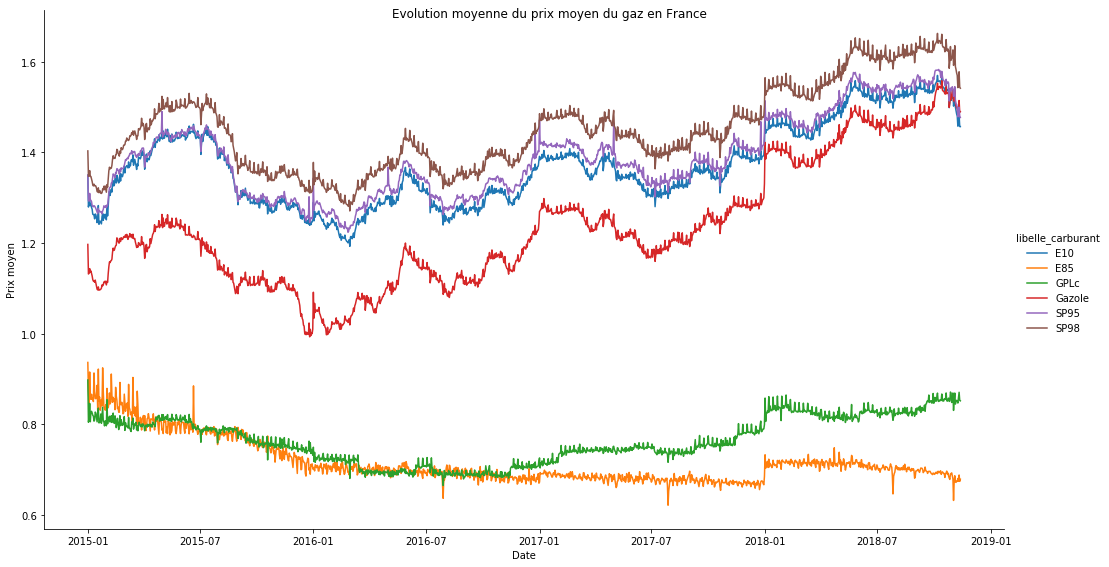

In [56]:
f1 = sns.FacetGrid(prix_quotidien_df.sort_values(by=['libelle_carburant', 'date_releve']), hue='libelle_carburant',
                      size=8, aspect=16/9)
f1.map(plt.plot, "date_releve", "prix_moyen")
f1.set_axis_labels('Date','Prix moyen')
f1.fig.suptitle("Evolution moyenne du prix moyen du gaz en France")
f1.add_legend()

### Représentation cartographique

#### Calculer l'indice moyen des prix par type de gaz sur l'ensemble des départements

In [57]:
prix_moyen_depart = spark.sql(
    'SELECT DISTINCT libelle_carburant, int(round(code_postal/1000, 0)) as departement, avg(indice_prix) as index_moyen '
    'FROM prix_df '
    'WHERE libelle_carburant is not null '
    'GROUP BY departement, libelle_carburant '
    'ORDER BY departement '
).toPandas()

In [58]:
prix_moyen_depart.head()

,libelle_carburant,departement,index_moyen
0,E85,1,9.378861
1,GPLc,1,11.627235
2,SP95,1,0.965387
3,Gazole,1,2.335176
4,E10,1,2.356349


In [59]:
prix_moyen_depart_E10 = prix_moyen_depart[ prix_moyen_depart ['libelle_carburant']=='E10'].set_index('departement', drop=True)
prix_moyen_depart_E10 = prix_moyen_depart_E10.drop('libelle_carburant', axis=1)
dict_depart_E10 = prix_moyen_depart_E10.to_dict()

prix_moyen_depart_E85 = prix_moyen_depart[ prix_moyen_depart ['libelle_carburant']=='E85'].set_index('departement', drop=True)
prix_moyen_depart_E85 = prix_moyen_depart_E85.drop('libelle_carburant', axis=1)
dict_depart_E85 = prix_moyen_depart_E85.to_dict()

prix_moyen_depart_GPLc = prix_moyen_depart[ prix_moyen_depart ['libelle_carburant']=='GPLc'].set_index('departement', drop=True)
prix_moyen_depart_GPLc = prix_moyen_depart_GPLc.drop('libelle_carburant', axis=1)
dict_depart_GPLc = prix_moyen_depart_GPLc.to_dict()

prix_moyen_depart_Gazole = prix_moyen_depart[ prix_moyen_depart ['libelle_carburant']=='Gazole'].set_index('departement', drop=True)
prix_moyen_depart_Gazole = prix_moyen_depart_Gazole.drop('libelle_carburant', axis=1)
dict_depart_Gazole = prix_moyen_depart_Gazole.to_dict()

prix_moyen_depart_SP95 = prix_moyen_depart[ prix_moyen_depart ['libelle_carburant']=='SP95'].set_index('departement', drop=True)
prix_moyen_depart_SP95 = prix_moyen_depart_SP95.drop('libelle_carburant', axis=1)
dict_depart_SP95 = prix_moyen_depart_SP95.to_dict()

prix_moyen_depart_SP98 = prix_moyen_depart[ prix_moyen_depart ['libelle_carburant']=='SP98'].set_index('departement', drop=True)
prix_moyen_depart_SP98 = prix_moyen_depart_SP98.drop('libelle_carburant', axis=1)
dict_depart_SP98 = prix_moyen_depart_SP98.to_dict()

#### Représenter les cartes thermiques de l'indice moyen des prix du département France pour chaque type de gaz

In [60]:
France_prixmoy_gaz = pygal.maps.fr.Departments(human_readable=True)
France_prixmoy_gaz.title = 'Average index price by department'
France_prixmoy_gaz.add('Gaz E10', dict_depart_E10['index_moyen'])
France_prixmoy_gaz.render_in_browser()

file:///var/folders/t8/tnlxynjx3yn4dzfn_z7j1tjr0000gn/T/tmprfida8up.html


In [61]:
France_prixmoy_gaz = pygal.maps.fr.Departments(human_readable=True)
France_prixmoy_gaz.title = 'Average index price by department'
France_prixmoy_gaz.add('Gaz E85', dict_depart_E85['index_moyen'])
France_prixmoy_gaz.render_in_browser()

file:///var/folders/t8/tnlxynjx3yn4dzfn_z7j1tjr0000gn/T/tmph960zo0a.html


In [62]:
France_prixmoy_gaz = pygal.maps.fr.Departments(human_readable=True)
France_prixmoy_gaz.title = 'Prix moyen de l"indice par département'
France_prixmoy_gaz.add('Gaz GPLc', dict_depart_GPLc['index_moyen'])
France_prixmoy_gaz.render_in_browser()

file:///var/folders/t8/tnlxynjx3yn4dzfn_z7j1tjr0000gn/T/tmpzbi4t4ir.html


In [63]:
France_prixmoy_gaz = pygal.maps.fr.Departments(human_readable=True)
France_prixmoy_gaz.title = 'Prix moyen de l"indice par département'
France_prixmoy_gaz.add('Gaz Gazole', dict_depart_Gazole['index_moyen'])
France_prixmoy_gaz.render_in_browser()

file:///var/folders/t8/tnlxynjx3yn4dzfn_z7j1tjr0000gn/T/tmpij5f41z1.html


In [64]:
France_prixmoy_gaz = pygal.maps.fr.Departments(human_readable=True)
France_prixmoy_gaz.title = 'Prix moyen de l"indice par département'
France_prixmoy_gaz.add('Gaz SP95', dict_depart_SP95['index_moyen'])
France_prixmoy_gaz.render_in_browser()

file:///var/folders/t8/tnlxynjx3yn4dzfn_z7j1tjr0000gn/T/tmpy2435p5j.html


In [65]:
France_prixmoy_gaz = pygal.maps.fr.Departments(human_readable=True)
France_prixmoy_gaz.title = 'Prix moyen de l"indice par département'
France_prixmoy_gaz.add('Gaz SP98', dict_depart_SP98['index_moyen'])
France_prixmoy_gaz.render_in_browser()

file:///var/folders/t8/tnlxynjx3yn4dzfn_z7j1tjr0000gn/T/tmpv3ex2apy.html


# Modeling 1 - Prix prévu pour le lendemain

Construire un modèle basé sur Spark MLlibto prévoir le prix du lendemain pour un type de gaz dans une station.

• Fournir des mesures de précision pertinentes et un graphique de dispersion pertinent entre les mesures réelles et les prévisions.

• Conseils : envisagez d'utiliser les fonctions de retard (comme le prix de la veille, le prix de la veille, la veille, etc.) pour construire le modèle.

• Avis important : nous ne nous attendons pas à ce que le modèle soit peaufiné, mais plutôt à ce qu'il soit fonctionnel.

In [66]:
prix_df2 = spark.sql(
    'SELECT DISTINCT id_unique, type_carburant, libelle_carburant, date(date_releve) as date_releve, prix_moyen, prix '
    'FROM prix_df '
    'WHERE type_carburant=1 AND id_unique=1160005 '
    'ORDER BY date_releve, type_carburant '
).dropna().cache()

In [67]:
from pyspark.sql import functions as F

##### Creation d'une fonction retard (lag)

In [68]:
w = Window.partitionBy().orderBy("id_unique","libelle_carburant","date_releve")

In [69]:
prix_df2 = prix_df2.withColumn("prix_1", F.lag(prix_df2.prix).over(w))
prix_df2 = prix_df2.withColumn("prix_2", F.lag(prix_df2.prix_1).over(w))
prix_df2 = prix_df2.withColumn("prix_3", F.lag(prix_df2.prix_2).over(w))
prix_df2 = prix_df2.withColumn("prix_4", F.lag(prix_df2.prix_3).over(w))
prix_df2 = prix_df2.withColumn("prix_5", F.lag(prix_df2.prix_4).over(w))
prix_df2 = prix_df2.withColumn("prix_6", F.lag(prix_df2.prix_5).over(w))
prix_df2 = prix_df2.withColumn("prix_7", F.lag(prix_df2.prix_6).over(w))
prix_df2 = prix_df2.withColumn("prix_8", F.lag(prix_df2.prix_7).over(w))

In [70]:
prix_df2.printSchema()

root
 |-- id_unique: integer (nullable = true)
 |-- type_carburant: integer (nullable = true)
 |-- libelle_carburant: string (nullable = true)
 |-- date_releve: date (nullable = true)
 |-- prix_moyen: double (nullable = true)
 |-- prix: double (nullable = true)
 |-- prix_1: double (nullable = true)
 |-- prix_2: double (nullable = true)
 |-- prix_3: double (nullable = true)
 |-- prix_4: double (nullable = true)
 |-- prix_5: double (nullable = true)
 |-- prix_6: double (nullable = true)
 |-- prix_7: double (nullable = true)
 |-- prix_8: double (nullable = true)



Ici, nous avons créé un nouveau dataframe où nous avons ajouté 8 nouvelles colonnes, chacune représentant un décalage par rapport à la période précédente. De cette façon, nous avons pour la même ligne le prix  d'aujourd'hui, de la veille et ce pour 8 jours.

In [71]:
prix_df2=prix_df2.dropna()

In [72]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [73]:
vectorAssembler = VectorAssembler(inputCols = ['prix_1','prix_2','prix_3','prix_4','prix_5','prix_6','prix_7','prix_8'], outputCol = 'features')
vprix_df2 = vectorAssembler.transform(prix_df2)
vprix_df2 = vprix_df2.select(['features', 'prix'])

Nous utilisons le Train/test pour mettre en œuvre notre régression et ensuite faire notre prédiction.

In [74]:
split = vprix_df2.randomSplit([0.7, 0.3])
train_df = split[0]
test_df = split[1]

On met en place la régression linéaire sur le train pour obtenir les coefficients de notre régression

In [76]:
lr = LinearRegression(featuresCol = 'features', labelCol='prix')
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [1.1609570898113637,-0.11999600326939856,0.004867267514196716,-0.029409104199104922,-0.003738348300285651,0.013189293702765668,-0.013219816223766038,-0.011814775861120532]
Intercept: -0.0009540986764974766


Résumer le modèle régressé par rapport au train : 
- RMSE nous donne la différence entre les valeurs prévues et les valeurs actuelles que nous avons.
- R2 indique que la variabilité de notre variable est expliquée par le modèle a plus de 99%

In [79]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 0.006177
r2: 0.997720


Faire la prédiction à l'aide de la régression linéaire sur le test_df pour prévoir les prix futurs

In [80]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","prix","features").show(5)

+------------------+-----+--------------------+
|        prediction| prix|            features|
+------------------+-----+--------------------+
|0.9679877771195887|0.969|[0.969,0.969,0.96...|
|0.9658488617754614|0.969|[0.969,0.985,0.98...|
|0.9713245250793312|0.972|[0.972,0.972,0.97...|
|0.9705498415720809|0.972|[0.972,0.972,0.98...|
|0.9681478115425487|0.972|[0.972,0.989,0.99...|
+------------------+-----+--------------------+
only showing top 5 rows



In [81]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="prix",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

R Squared (R2) on test data = 0.998445
Root Mean Squared Error (RMSE) on test data = 0.00564782


In [82]:
lr_predictions = lr_predictions.toPandas()

On convertit notre tableau de prédiction sous Pandas pour pouvoir faire un graphique

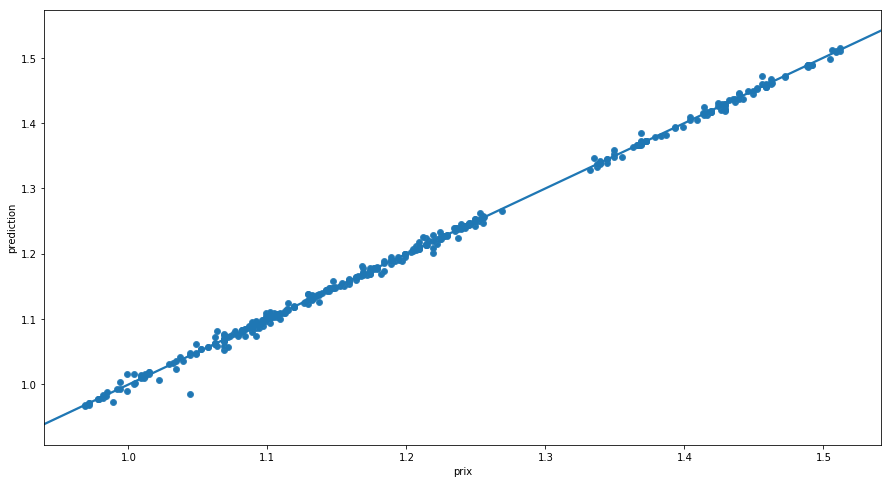

In [89]:
plt.figure(figsize=(15,8))
sns.scatterplot(x = 'prix', y = 'prediction', data = lr_predictions)
sns.regplot(x = 'prix', y = 'prediction', data = lr_predictions)

Le graphique proposé entre les prix et les prédictions nous montre une précision élevée, car les point sont relativement proche de la droite de régression. On peut donc faire relativement confiance aux prédictions effectuées